# Voice Cloning detection 

## Links of interest

### Data sets
- https://lionbridge.ai/datasets/best-speech-recognition-datasets-for-machine-learning/
- https://data.mendeley.com/datasets/k47yd3m28w/2
- https://keithito.com/LJ-Speech-Dataset/
- https://www.kaggle.com/charlesaverill/imagenet-voice
- https://www.kaggle.com/fabawi/augmented-extended-train-robots
- https://www.kaggle.com/jbuchner/synthetic-speech-commands-dataset
- https://www.kaggle.com/primaryobjects/voicegender

### Articles & Studies
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7058910/
- https://yorkspace.library.yorku.ca/xmlui/bitstream/handle/10315/36698/Reimao_Ricardo_AM_2019_Masters.pdf?sequence=2
- https://r9y9.github.io/deepvoice3_pytorch/

In [12]:
import os
import scipy
import requests
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob as globlin
from helpers import *
from tempfile import mktemp
from subprocess import check_call
import pydub
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tempfile import mktemp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Reading VCTK real human speaker data

In [13]:
vctk_info_df = pd.read_table('./Data/VCTK/VCTK-Corpus/VCTK-Corpus/speaker-info.txt', sep ='\s+', index_col=False)
vctk_info_df.head(5)

,ID,AGE,GENDER,ACCENTS,REGION
0,225,23,F,English,Southern
1,226,22,M,English,Surrey
2,227,38,M,English,Cumbria
3,228,22,F,English,Southern
4,229,23,F,English,Southern


In [14]:
number_of_real_speakers('./Data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/*')

44243

## Reading Generated Data

In [15]:
gen_data_annotations = pd.read_csv('./Data/GeneratedData/SpeechMultimodalCSV/virtual/Annotations/all.csv', sep='\t')
gen_data_annotations.head(5)

,mr_link,ref,id,mutated
0,{DS_PATH}/GeneratedData/SpeechMultimodalCSV/vi...,This is the first test .,100001,False
1,{DS_PATH}/GeneratedData/SpeechMultimodalCSV/vi...,move the red brick in the corner and place it ...,15,False
2,{DS_PATH}/GeneratedData/SpeechMultimodalCSV/vi...,place green pyramid on top of red brick,19,False
3,{DS_PATH}/GeneratedData/SpeechMultimodalCSV/vi...,place the red pyramid sitting on top of the re...,28,False
4,{DS_PATH}/GeneratedData/SpeechMultimodalCSV/vi...,Move the blue block on top of the grey block .,34,False


In [16]:
len(gen_data_annotations)

186504

In [17]:
mp3filename = gen_data_annotations['mr_link'].iloc[0].replace(
    '{DS_PATH}', 
    '/Users/ahmadchaiban/Desktop/Guelph/6550_project/Data'
)
mp3filename

'/Users/ahmadchaiban/Desktop/Guelph/6550_project/Data/GeneratedData/SpeechMultimodalCSV/virtual/MP3Audio/en-US-Wavenet-B/100001.mp3'

## Converted mp3 files to wav

In [18]:
# convert_files_to_wav(gen_data_annotations['mr_link'], '/Users/ahmadchaiban/Desktop/Guelph/6550_project/Data/generated_wav')

## Sample Spectrogram

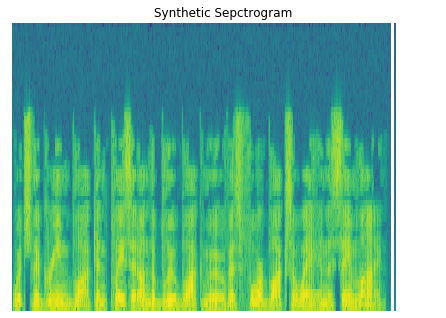

In [19]:
FS, data = wavfile.read('output.wav')  # read wav file
fig,ax = plt.subplots(1)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax.specgram(data, Fs=FS, NFFT=128, noverlap=0)  # plot
ax.axis('tight')
ax.axis('off')
plt.title("Synthetic Sepctrogram")
plt.savefig('spectrogram_synthetic sample')
plt.show()

In [20]:
# extract_spectrogram_from_audio('./Data/generated_wav/*.wav', './Data/generated_spectos/')

In [21]:
# extract_spectrogram_from_audio('./Data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/**/*.wav', './Data/real_spectos/')

## Loading image Arrays

In [22]:
generated_images_dataset, generated_classes = load_images_as_dataframe('./Data/generated_spectos/*.jpg', 1)

100% (44084 of 44084) |##################| Elapsed Time: 0:01:07 Time:  0:01:07


In [23]:
real_images_dataset, real_classes = load_images_as_dataframe('./Data/real_spectos/*.jpg', 0)

100% (44242 of 44242) |##################| Elapsed Time: 0:01:24 Time:  0:01:24


In [24]:
print('Number of synthetic voices = ' + str(len(generated_images_dataset)))
print('Number of real voices = ' + str(len(real_images_dataset)))

Number of synthetic voices = 44084
Number of real voices = 44242


In [25]:
images_dataset = np.concatenate((generated_images_dataset, real_images_dataset), axis=0)
classes_dataset = np.concatenate((generated_classes, real_classes), axis=0)
print('Total Number of Voices = ' + str(len(images_dataset)))

Total Number of Voices = 88326


## Feature Extraction

In [26]:
# model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# predictions = model.predict(images_dataset[:, 0])
# pred_images = predictions.reshape(images_dataset[:, 0].shape[0], -1)

## K-means clustering

## Train-Test Split

In [27]:
X = images_dataset
y = classes_dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Synthetic voices training samples = 29464
Real voices training samples = 29714
Synthetic test samples = 14620
Real test samples = 14528


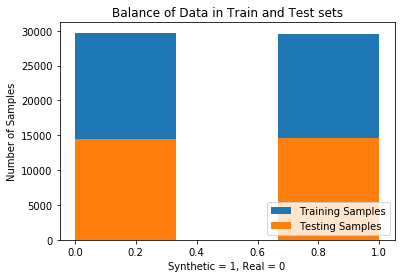

In [29]:
print(f"Synthetic voices training samples = {len(np.where(y_train == 1)[0])}")
print(f"Real voices training samples = {len(np.where(y_train == 0)[0])}")
print(f"Synthetic test samples = {len(np.where(y_test == 1)[0])}")
print(f"Real test samples = {len(np.where(y_test == 0)[0])}")

plt.hist(x = y_train, bins=3)
plt.hist(x = y_test, bins=3)
plt.legend(["Training Samples", "Testing Samples"], loc ="lower right") 
plt.xlabel("Synthetic = 1, Real = 0")
plt.ylabel("Number of Samples")
plt.title("Balance of Data in Train and Test sets")
plt.show()

## LeNet - 5 Classifier

### LeNet Architecture
<center>
    <img src="./doc_images/lenet_arch.png"/>
</center>

However, please note that the input for this model is 224, 224, 3

In [44]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Flatten, Dense

LeNet = Sequential([
    
    Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(224, 224, 3)),

    Conv2D(filters=24, kernel_size=(5, 5), activation='relu', strides=(1, 1), padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(filters=36, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(filters=48, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(120, activation='relu', kernel_regularizer='l2'),
    Dense(84, activation='relu'),
    Dense(2, activation='softmax')
])

In [45]:
epochs = 5
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, name='adam')
loss_function = tf.keras.losses.binary_crossentropy

LeNet.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

history = LeNet.fit(x=X_train,
                   y=y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_split=0.2)

Epoch 1/5
  49/1480 [..............................] - ETA: 16:01 - loss: 8.8333 - accuracy: 0.5096

KeyboardInterrupt: 

In [ ]:
y_pred = LeNet.predict(X_test)
score = accuracy_score(y_test, y_pred)

## nVidia Classifier